# Clustering Alerts by Command line and Process Name Patterns
Author: Tim Burrell, Ian Hellen

In [2]:
import numpy as np
import scipy.linalg as lin
import Levenshtein as leven
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import itertools
import ipywidgets as widgets
from ipywidgets import interactive, Layout
import pandas as pd
from IPython.display import display

from azure.kusto.data.request import KustoClient

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 100) 

In [5]:
# Function to translate response into pandas data frame
# I imported this and modified from Kusto client source since it seemed to break whenever I used it
# Preferred interface is dataframe_from_response
def dataframe_from_result_table(table, raise_errors=True):
    import pandas
    import json

    kusto_to_dataframe_data_types = {
        "bool": "bool",
        "uint8": "int64",
        "int16": "int64",
        "uint16": "int64",
        "int": "int64",
        "uint": "int64",
        "long": "int64",
        "ulong": "int64",
        "float": "float64",
        "real": "float64",
        "decimal": "float64",
        "string": "object",
        "datetime": "datetime64[ns]",
        "guid": "object",
        "timespan": "timedelta64[ns]",
        "dynamic": "object",
        # Support V1
        "DateTime": "datetime64[ns]",
        "Int32": "int32",
        "Int64": "int64",
        "Double": "float64",
        "String": "object",
        "SByte": "object",
        "Guid": "object",
        "TimeSpan": "object",
    }
    
    """Returns Pandas data frame."""
    if not table.columns: #or not table.rows:
        return pandas.DataFrame()

    rows = []
    for row in table:
        cols = []
        for col in row:
            cols.append(col)
        rows.append(cols)
        
    frame = pandas.DataFrame(rows, columns=[column.column_name for column in table.columns])

    for column in table.columns:
        col_name = column.column_name
        col_type = column.column_type
        if col_type.lower() == "timespan":
            frame[col_name] = pandas.to_timedelta(
                frame[col_name].apply(lambda t: t.replace(".", " days ") if t and "." in t.split(":")[0] else t)
            )
        elif col_type.lower() == "dynamic":
            frame[col_name] = frame[col_name].apply(lambda x: json.loads(x) if x else None)
        elif col_type in kusto_to_dataframe_data_types:
            pandas_type = kusto_to_dataframe_data_types[col_type]
            frame[col_name] = frame[col_name].astype(pandas_type, errors="raise" if raise_errors else "ignore")

    return frame

from azure.kusto.data._models import WellKnownDataSet
def dataframe_from_response(response, raise_errors=True):
    results_table = [t for t in response.tables if t.table_kind == WellKnownDataSet.PrimaryResult]
    query_completion_table = [t for t in response.tables if t.table_kind == WellKnownDataSet.QueryCompletionInformation]
    
    if len(query_completion_table) == 1 and query_completion_table[0].rows[1][7] != 0:
        print('None-zero status returned in Kusto query')
        print(query_completion_table[0].rows)
    
    if len(results_table) > 0:
        return dataframe_from_result_table(results_table[0], raise_errors)

# structure of Kusto Query Response
# [KustoResultColumn({"ColumnName": "Timestamp", "ColumnType": "datetime"},0),
#  KustoResultColumn({"ColumnName": "ClientRequestId", "ColumnType": "string"},1),
#  KustoResultColumn({"ColumnName": "ActivityId", "ColumnType": "guid"},2),
#  KustoResultColumn({"ColumnName": "SubActivityId", "ColumnType": "guid"},3),
#  KustoResultColumn({"ColumnName": "ParentActivityId", "ColumnType": "guid"},4),
#  KustoResultColumn({"ColumnName": "Level", "ColumnType": "int"},5),
#  KustoResultColumn({"ColumnName": "LevelName", "ColumnType": "string"},6),
#  KustoResultColumn({"ColumnName": "StatusCode", "ColumnType": "int"},7),
#  KustoResultColumn({"ColumnName": "StatusCodeName", "ColumnType": "string"},8),
#  KustoResultColumn({"ColumnName": "EventType", "ColumnType": "int"},9),
#  KustoResultColumn({"ColumnName": "EventTypeName", "ColumnType": "string"},10),
#  KustoResultColumn({"ColumnName": "Payload", "ColumnType": "string"},11)]

# Allows printing of query with stripped commments and newline chars
def print_kql(query):
    import re
    remove_comments = re.sub(r'(//[^\"\'\n]+)', '', query, re.MULTILINE)
    print(remove_comments.replace('\n', ''))

#from kusto_client import KustoClient

kusto_cluster = 'https://Ascprodus.kusto.windows.net'
kusto_alerts = 'ProdAlerts'
kusto_events = 'ProdRawEvents'

kusto_client = KustoClient(kusto_cluster)

In [6]:
lookbackHours = widgets.IntSlider(value=12, min=1, max=240, step=1,
    description='Number of hours to look back:',
    layout=Layout(width='80%'),
    style = {'description_width': 'initial'})

display(lookbackHours)

IntSlider(value=12, description='Number of hours to look back:', layout=Layout(width='80%'), max=240, min=1, s…

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code B6FE5FJZD to authenticate.


,AlertType,alertcount,subcount
0,SCUBA_RAREEXECUTION,3374,175
1,SCUBA_PROCESSNAMESIMILARITY,1937,72
2,SCUBA_RANDOMPROCESSNAME,1902,160
3,SCUBA_RULE_KnownCredentialAccessTools,687,9
4,SCUBA_RULE_Burst_of_attempts_to_add_user_to_the_local_administrators_group,559,11
5,SCUBA_ADMINISTRATORSREMOTEENUM,210,62
6,SCUBA_COMMANDLINEMISMATCH,118,10
7,SCUBA_RULE_DownloadFileThenRun,94,5
8,SCUBA_RULE_Account_Creation,85,23
9,SCUBA_SOUNDER,74,33


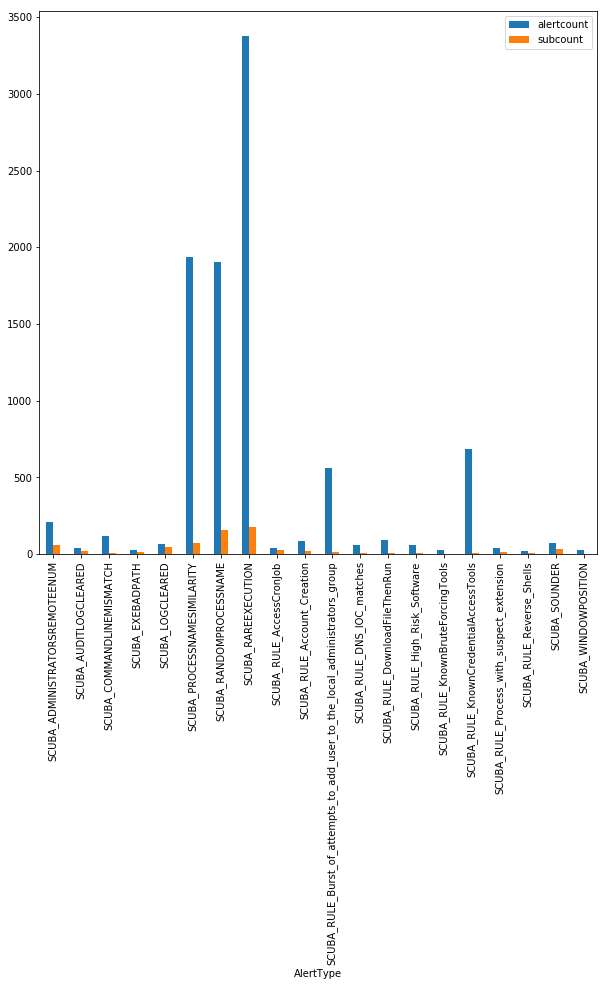

In [7]:
query='''DispatcherAlerts 
| where StartTimeUtc > ago({hours}h) 
| where AlertType startswith "SCUBA"
| where AlertType != 'SCUBA_RULE_ASC_EICAR'
| where CompromisedEntity !contains "e2e"
| where CompromisedEntity !contains "honeypot"
| where CompromisedEntity !contains "oms-agent"
| where CompromisedEntity !contains "scuba"
| extend subscription = iff(isempty(AzureResourceSubscriptionId), WorkspaceSubscriptionId, AzureResourceSubscriptionId)
| summarize alertcount=count(), subcount = dcount(subscription) by AlertType
| order by alertcount desc'''.format(hours=lookbackHours.value)

alert_counts = dataframe_from_response(kusto_client.execute(kusto_alerts, query))

display(alert_counts.head(10))
plt.rcParams['figure.figsize'] = (10,10)
top_alerts = alert_counts.head(20).groupby('AlertType').sum().plot.bar()

In [9]:
# Allow subscription to be selected

items = alert_counts.sort_values('alertcount', ascending=False)['AlertType'].unique().tolist()
 
selected_alert = widgets.Select(options=items, 
                              description='Select the alert type :',
                              layout=Layout(width='50%', height='200px'),
                              style = {'description_width': 'initial'})
display(selected_alert)

Select(description='Select the alert type :', layout=Layout(height='200px', width='50%'), options=('SCUBA_RARE…

In [101]:
invQuery2 = '''
DispatcherAlerts
| where AlertType == "{alertType}"
| where StartTimeUtc >= ago({hours}h)
| where CompromisedEntity !contains "e2e"
| where CompromisedEntity !contains "honeypot"
| where CompromisedEntity !contains "oms-agent"
| order by StartTimeUtc desc
| where Severity != "Silent"
| extend cmdline= tostring(ExtendedProperties['Suspicious Command Line'])
| extend process = tostring(ExtendedProperties['Suspicious Process'])
| extend cmdline_len = strlen(cmdline)
| extend cmdline_tokens = array_length(split(cmdline, \' \'))
| extend path_len = strlen(process)
| extend separator = iif(indexof(process, '\\\\') == -1, '/', '\\\\')
| extend processParts = split(process, separator)
| extend processName = tostring(processParts[ -1 ])
| summarize count() by process, cmdline, cmdline_len, cmdline_tokens, path_len, processName
| order by count_ desc
| sample 100
'''.format(alertType=selected_alert.value, hours=lookbackHours.value)

alerts = dataframe_from_response(kusto_client.execute(kusto_alerts, invQuery2))
alerts

,process,cmdline,cmdline_len,cmdline_tokens,path_len,processName,count_
0,f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe,f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe,74,1,74,i8_cs_ro.exe,2
1,f:\j7\netfxdev1\self_host_tests_x86\jit\methodical\fp\exgen\1000w1d_cs_d.exe,f:\j7\netfxdev1\self_host_tests_x86\jit\methodical\fp\exgen\1000w1d_cs_d.exe,76,1,76,1000w1d_cs_d.exe,1
2,f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sf1g_d.exe,f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sf1g_d.exe,69,1,69,hfa_sf1g_d.exe,1
3,f:\j6\codegenmirror\self_host_tests_x86\jit\methodical\asgop\i8\i8_cpp_d.exe,f:\j6\codegenmirror\self_host_tests_x86\jit\methodical\asgop\i8\i8_cpp_d.exe,76,1,76,i8_cpp_d.exe,1
4,f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe,101,1,101,xcpt4me.exe,1
5,f:\j3\codegenmirror\self_host_tests_x86\jit\jit64\hfa\main\hfa_nf3h.exe,f:\j3\codegenmirror\self_host_tests_x86\jit\jit64\hfa\main\hfa_nf3h.exe,71,1,71,hfa_nf3h.exe,2
6,f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe,82,1,82,r4div_cs_r.exe,1
7,f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sd1h.exe,f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sd1h.exe,67,1,67,hfa_sd1h.exe,1
8,f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\arrays\il_rel\huge_u8.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\arrays\il_rel\huge_u8.exe,82,1,82,huge_u8.exe,1
9,c:\windows\syswow64\rundll32.exe,"""rundll32.exe"" ""d:\apps\usagepanel\e_upwj01.dll"",epgetversionex /log:""c:\users\i2-sal~1\appdata\local\temp\epson\osver\osv.log""",127,3,32,rundll32.exe,1


## Select a Clustering Size

Optimal cluster size where Elbow flattens


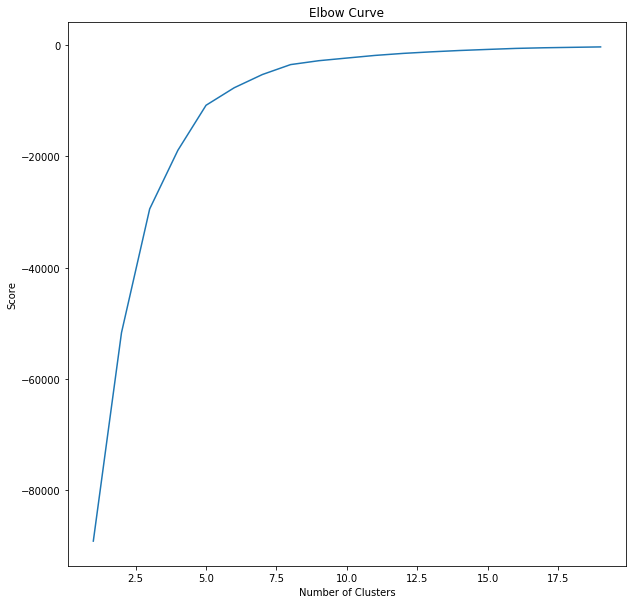

IntSlider(value=5, description='Select the alert type :', layout=Layout(height='50px', width='50%'), max=20, m…

[[ 0.07701448  0.99676762  0.02287084]
 [-0.99643365  0.07615491  0.03633757]]


In [102]:
from sklearn.cluster import KMeans
from itertools import cycle
import math

# f = lambda x,y: -leven.distance(x,y)

max_samples = min(alerts.shape[0],20)
# lev_similarity = np.array([[f(s1,s2) for s1 in strings] for s2 in strings])
X = alerts[['path_len', 'cmdline_len', 'cmdline_tokens']]
Nc = range(1, max_samples)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
print("Optimal cluster size where Elbow flattens")
plt.show()

cluster_size_wgt = widgets.IntSlider(value=5, min=1, max=20, step=1,
                              description='Select the alert type :',
                              layout=Layout(width='50%', height='50px'),
                              style = {'description_width': 'initial'})
display(cluster_size_wgt)


from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
print(pca.components_)
#pca_d = pca.transform(Y)

pca_c = pca.transform(X)

## Build and Plot Clusters

Cluster #: 0  Cluster size=32:  Exemplar: f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe:: f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe
Cluster #: 1  Cluster size=3:  Exemplar: c:\windows\system32\rundll32.exe:: "c:\windows\system32\rundll32.exe" iedkcs32.dll,brandcleaninstallstubs >{bc455173-f501-4356-804f-571fafb6ea9a}
Cluster #: 2  Cluster size=4:  Exemplar: c:\progra~1\lenovo\hotkey\tpnumlk.exe:: c:\progra~1\lenovo\hotkey\tpnumlk.exe
Cluster #: 3  Cluster size=4:  Exemplar: f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe:: f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe
Cluster #: 4  Cluster size=1:  Exemplar: d:\imageflow\apps\cxxlsxz.exe:: "d:/imageflow/apps/cxxlsxz.exe" "\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.xlsx" "\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox

,clusterid,size,proc_name,exemplar,CommandLine,ProcessName
0,0,32,[i8_cs_ro.exe],f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe:: f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe,f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe,f:\j3\netfxdev1\self_host_tests_amd64\jit\methodical\asgop\i8\i8_cs_ro.exe
1,1,3,[rundll32.exe],"c:\windows\system32\rundll32.exe:: ""c:\windows\system32\rundll32.exe"" iedkcs32.dll,brandcleaninstallstubs >{bc455173-f501-4356-804f-571fafb6ea9a}","""c:\windows\system32\rundll32.exe"" iedkcs32.dll,brandcleaninstallstubs >{bc455173-f501-4356-804f-571fafb6ea9a}",c:\windows\system32\rundll32.exe
2,2,4,[tpnumlk.exe],c:\progra~1\lenovo\hotkey\tpnumlk.exe:: c:\progra~1\lenovo\hotkey\tpnumlk.exe,c:\progra~1\lenovo\hotkey\tpnumlk.exe,c:\progra~1\lenovo\hotkey\tpnumlk.exe
3,3,4,[xcpt4me.exe],f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe:: f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\jit64\ebvts\mcpp\sources2\comeh\seh\seh.001\xcpt4me.exe
4,4,1,[cxxlsxz.exe],"d:\imageflow\apps\cxxlsxz.exe:: ""d:/imageflow/apps/cxxlsxz.exe"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.xlsx"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.tif"" ""","""d:/imageflow/apps/cxxlsxz.exe"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.xlsx"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.tif"" """,d:\imageflow\apps\cxxlsxz.exe
5,5,1,[uwpaxis.exe],"c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe:: ""c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe"" -servername:app.appxaxsn5r4fdfgz2d0z6ng9r4cb6qp2xqb0.mca","""c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe"" -servername:app.appxaxsn5r4fdfgz2d0z6ng9r4cb6qp2xqb0.mca",c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe
6,6,1,[xgkohbgnd.exe],c:\windows\system32\xgkohbgnd.exe::,,c:\windows\system32\xgkohbgnd.exe
7,7,28,[hfa_sf1g_d.exe],f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sf1g_d.exe:: f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sf1g_d.exe,f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sf1g_d.exe,f:\j6\netfxdev1\self_host_tests_x86\jit\jit64\hfa\main\hfa_sf1g_d.exe
8,8,3,[iv_ivp321.exe],"d:\amt\apps\fredsinc_amtlion\batchworking\amt_batchcontroller2\reportpool.361\iv_ivp321.exe:: ""d:\amt\apps\fredsinc_amtlion\batchworking\amt_batchcontroller2\reportpool.361\iv_ivp321.exe"" /r:3640784 /useworkingdir","""d:\amt\apps\fredsinc_amtlion\batchworking\amt_batchcontroller2\reportpool.361\iv_ivp321.exe"" /r:3640784 /useworkingdir",d:\amt\apps\fredsinc_amtlion\batchworking\amt_batchcontroller2\reportpool.361\iv_ivp321.exe
9,9,19,[r4div_cs_r.exe],f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe:: f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe,f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe


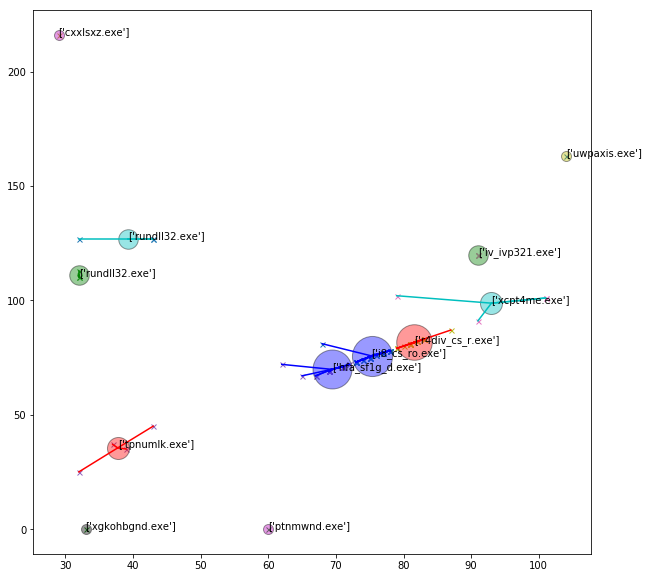

In [105]:
from sklearn.cluster import KMeans
from itertools import cycle
import math

km_cluster = KMeans(n_clusters=cluster_size_wgt.value)
km_cluster.fit(X)
#print(X)
#print(km_cluster.labels_)
cluster_set, counts = np.unique(km_cluster.labels_, return_counts=True)
max_cluster_id = -1
max_cluster_size = -1
max_cluster_exemplar = ""
min_cluster_id = -1
min_cluster_size = 100
min_cluster_exemplar = ""
exemplars = {}

cluster_list = []
#print(km_cluster.labels_)
for cluster_id in cluster_set:
    cluster_center = km_cluster.cluster_centers_[cluster_id]
    #print('center', cluster_center)
    class_members = km_cluster.labels_ == cluster_id
                 
    label_strings = [':: '.join(alerts.loc[i][['process', 'cmdline']].values) for i in X[class_members].index]
    proc_name = [alerts.loc[i][['processName']].values for i in X[class_members].index][0]
    exemplar = label_strings[0]
    exemplars[cluster_id] = proc_name
    #print('strings', label_strings)
    
    cluster_size = counts[cluster_id]
    if (cluster_size > max_cluster_size):
        max_cluster_size = cluster_size
        max_cluster_id = cluster_id
        max_cluster_exemplar = exemplar

    if(cluster_size < min_cluster_size):
        min_cluster_size = cluster_size
        min_cluster_id = cluster_id
        min_cluster_exemplar = exemplar
        
    print('Cluster #: {cluster_id}  Cluster size={size}:  Exemplar: {exemplar}'.format(
        cluster_id= cluster_id, size=cluster_size, exemplar=exemplar ))
    cluster_list.append(pd.Series({'clusterid':cluster_id, 'size':cluster_size, 'proc_name':proc_name, 'exemplar': exemplar }))


print("Number of clusters: ", counts)
print("Largest cluster %d of size %d" % (max_cluster_id, max_cluster_size))
print("Exemplar:", max_cluster_exemplar)

results_df = pd.DataFrame(cluster_list)
results_df["CommandLine"] = results_df.apply(lambda x: x.exemplar.split('::')[-1].strip(), axis=1)
results_df["ProcessName"] = results_df.apply(lambda x: x.exemplar.split('::')[0].strip(), axis=1)
display(results_df)



colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# cluster_centers_indices = affprop.cluster_centers_indices_
n_clusters_ = len(counts)
# print('n_clusters_', n_clusters_)
labels = km_cluster.labels_
#print(labels)
# X = lev_similarity
ax = plt.gca()
km_cluster.cluster_centers_
for k, col in zip(range(n_clusters_), colors):
    #print('k', k)
    class_members = labels == k
    cluster_center = km_cluster.cluster_centers_[k]
    #print('center', cluster_center)
    
    cluster_center = km_cluster.cluster_centers_[k]
    plt.plot(X[class_members][['path_len']].values, 
             X[class_members][['cmdline_len']].values, 'x', markersize=5,
             markerfacecolor=col)
    cluster_size = (1 + 2 * math.log(counts[k], 10)) * 10
    
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=cluster_size, alpha=0.4)
    ax.annotate(exemplars[k], (cluster_center[0], cluster_center[1]))
    for x,y in X[class_members][['cmdline_len', 'path_len']].values:
        plt.plot([cluster_center[0], y], [cluster_center[1], x], col)

## Commonest Repetitions

In [104]:
def escape_windows_path(str_path):
    if str_path and str_path.strip():
        return str_path.replace('\\', '\\\\')

def escape_quotes(str_path):
    if str_path and str_path.strip():
        return str_path.replace('"', '\\"').replace('\'', '\\\'')
    
searched_commandline = max_cluster_exemplar.split('::')[-1].strip()
    
## Investigate an alert
instanceQuery = '''DispatcherAlerts
| where AlertType == "{alertType}"
| where StartTimeUtc >= ago({hours}h)
| where CompromisedEntity !contains "e2e"
| where CompromisedEntity !contains "honeypot"
| where CompromisedEntity !contains "oms-agent"
| where tostring(ExtendedProperties['Suspicious Command Line']) == \'{commandline}\'
| take 1
'''.format(alertType=selected_alert.value, commandline=escape_windows_path(searched_commandline), hours=lookbackHours.value)

instance = dataframe_from_response(kusto_client.execute(kusto_alerts, instanceQuery))
print("Maximum cluster example alert")
#print(instance.iloc[0])

display(instance.head(1))
print("Extended Properties")
print(instance.iloc[0].ExtendedProperties)
print("Entities")
print(instance.iloc[0].Entities)

Maximum cluster example alert


,IngestorMetadata,StartTimeUtc,EndTimeUtc,ProviderAlertId,ProviderName,VendorName,AlertType,Severity,IsIncident,ExtendedProperties,CompromisedEntity,Entities,ConfidenceLevel,Intent,ExtendedLinks,AzureResourceId,AzureResourceSubscriptionId,WorkspaceId,AgentId,SystemSource,WorkspaceSubscriptionId,WorkspaceResourceGroup,TimeGeneratedUtc,Metadata,DispatchTimeUtc,WasMessageSent,ErrorMessage
0,"{'_SourceSequenceNumber': '3657728', '_SourceEhPartitionId': '9', '_SourceEhEnqueueTime': '2018-11-08T17:54:51.7390000Z', '_SourceLogicalName': 'eh-alertdispatcher-prod-01-p-cus/alerts-eventhub', '_SourceEhName': 'eh-alertdispatcher-prod-01-p-cus/alerts-eventhub'}",2018-11-08 17:54:46.113482,2018-11-08 17:54:46.113482,acd1680b-97b8-46ee-9052-7ae791b21ed3,Detection,Microsoft,SCUBA_RANDOMPROCESSNAME,Informational,False,"{'Compromised Host': 'DDAZTJIT022', 'Suspicious Command Line': 'f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe', 'Suspicious Process': 'f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe', 'Account Session Id': '0x18dfb', 'Suspicious Process Id': '0x618c', 'User Name': 'REDMOND\robox', 'Parent Process': 'c:\windows\system32\cmd.exe', 'ModelScore': '-14.18'}",DDAZTJIT022,"[{'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'REDMOND', 'NetBiosName': 'DDAZTJIT022', 'DnsDomain': 'REDMOND.CORP.MICROSOFT.COM', 'OsVersion': None, '$id': '1', 'HostName': 'DDAZTJIT022', 'OSFamily': 'Windows'}, {'Type': 'file', '$id': '2', 'Directory': 'c:\windows\system32', 'Name': 'cmd.exe'}, {'Type': 'process', 'CommandLine': '', 'ProcessId': '0x3888', '$id': '3', 'ImageFile': {'$ref': '2'}, 'Host': {'$ref': '1'}}, {'IsDomainJoined': True, 'Type': 'account', 'NTDomain': 'REDMOND', '$id': '4', 'Host': {'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'REDMOND', 'NetBiosName': 'DDAZTJIT022', 'DnsDomain': 'REDMOND.CORP.MICROSOFT.COM', 'OsVersion': None, 'HostName': 'DDAZTJIT022', 'OSFamily': 'Windows'}, 'Name': 'robox', 'LogonId': '0x18dfb', 'Sid': 'S-1-5-21-2127521184-1604012920-1887927527-15682369'}, {'Type': 'file', '$id': '5', 'Directory': 'f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div', 'Name': 'r4div_cs_r.exe'}, {'Type': 'process', 'CommandLine': 'f:\j6\codegenmirror\self_host_tests_amd64\jit\methodical\divrem\div\r4div_cs_r.exe', 'ProcessId': '0x618c', '$id': '6', 'CreationTimeUtc': '2018-11-08T17:54:46.1134829Z', 'ParentProcess': {'$ref': '3'}, 'ImageFile': {'$ref': '5'}, 'Host': {'$ref': '1'}, 'ElevationToken': 'Default', 'Account': {'$ref': '4'}}]",Unknown,Unknown,None,/subscriptions/427a78b6-0da9-40fd-b29f-c1d599be6d37/resourcegroups/clrjit2-usw-ddaztjit022-337237/providers/microsoft.compute/virtualmachines/ddaztjit022,427a78b6-0da9-40fd-b29f-c1d599be6d37,ca0d9496-c0d4-4dd9-b2fc-b5b5d2046bcf,49f66952-2069-4de7-bdd5-c1dccd055a53,,427a78b6-0da9-40fd-b29f-c1d599be6d37,defaultresourcegroup-eus,2018-11-08 17:54:48,"{'SourceTags.OriginalInsertionTimeUtc': '2018-11-08T17:54:46.0000000Z', 'SourceTags.RawEventSource': 'Scuba-InMemIngestor', 'SourceTags.SourceSystem': 'OdsService', 'DeploymentEnvironment': 'ASC_Windows', 'SourceTags.SourceEnv': 'AAPRODEUS', 'AzDetectId': '2532123', 'EventMessageEnqueuedTimeUtc': '2018-11-08T17:54:48.4340000Z', 'EventMessageReceivedTimeUtc': '2018-11-08T17:54:48.5551780Z', 'ResultAttributionTimeUtc': '2018-11-08T17:54:46.1134829Z', 'OriginatingObservationId': 'acd1680b-97b8-46ee-9052-7ae791b21ed3', 'ResultGenerationTimeUtc': '2018-11-08T17:54:48.5551780Z', 'DeploymentDescription': 'b8904578143f41149e977b980f3731b8:CdiConsumer_IN_59:Rome:2.0.0.11', 'IngestorSrcEventHubName': 'sb://nrt-scuba-dedicated-oms-eus-prod.servicebus.windows.net/ods-scuba-eus-prod-01', 'DetectionSource': 'Scuba', 'IngestorSrcEnqueueTime': '11/08/2018 17:54:46', 'IngestorSrcPartitionId': '27', 'RawEventSource': 'Scuba-InMemIngestor', 'EventAttributionTime': '2018-11-08T17:54:46.1134829Z', 'SecurityAlertVersion': '3.0', 'InMemMetadata': '{ ""RawEventSource""

Extended Properties
{'Compromised Host': 'DDAZTJIT022', 'Suspicious Command Line': 'f:\\j6\\codegenmirror\\self_host_tests_amd64\\jit\\methodical\\divrem\\div\\r4div_cs_r.exe', 'Suspicious Process': 'f:\\j6\\codegenmirror\\self_host_tests_amd64\\jit\\methodical\\divrem\\div\\r4div_cs_r.exe', 'Account Session Id': '0x18dfb', 'Suspicious Process Id': '0x618c', 'User Name': 'REDMOND\\robox', 'Parent Process': 'c:\\windows\\system32\\cmd.exe', 'ModelScore': '-14.18'}
Entities
[{'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'REDMOND', 'NetBiosName': 'DDAZTJIT022', 'DnsDomain': 'REDMOND.CORP.MICROSOFT.COM', 'OsVersion': None, '$id': '1', 'HostName': 'DDAZTJIT022', 'OSFamily': 'Windows'}, {'Type': 'file', '$id': '2', 'Directory': 'c:\\windows\\system32', 'Name': 'cmd.exe'}, {'Type': 'process', 'CommandLine': '', 'ProcessId': '0x3888', '$id': '3', 'ImageFile': {'$ref': '2'}, 'Host': {'$ref': '1'}}, {'IsDomainJoined': True, 'Type': 'account', 'NTDomain': 'REDMOND', '$id': '4', 'Host': {'I

## Rare Process Patterns - Smallest Clusters

In [107]:
def print_alert(command_line):
    ## Investigate an alert
    instanceQuery = '''DispatcherAlerts
    | where AlertType == "{alertType}"
    | where StartTimeUtc >= ago({hours}h)
    | where CompromisedEntity !contains "e2e"
    | where CompromisedEntity !contains "honeypot"
    | where CompromisedEntity !contains "oms-agent"
    | where tostring(ExtendedProperties['Suspicious Command Line']) == \'{commandline}\'
    '''.format(alertType=selected_alert.value, commandline=command_line, hours=lookbackHours.value)

    instance = dataframe_from_response(kusto_client.execute(kusto_alerts, instanceQuery))
    
    #print(instance.iloc[0])
    
    display(instance)

print("Minimum cluster size alerts")
print('-' * 50)
for row in results_df.query('size <= 1')[['ProcessName', 'CommandLine', 'size']].itertuples():
    print('Cluster size: ', row.size)
    print('Command line: ', row.CommandLine)
    if(len(row.CommandLine.strip()) > 0):
        cmdline = escape_windows_path(row.CommandLine)
        cmdline = escape_quotes(cmdline)
        print_alert(cmdline)
    else:
        print("Empty commandline for process: ", row.ProcessName)

Minimum cluster size alerts
--------------------------------------------------
Cluster size:  1
Command line:  "d:/imageflow/apps/cxxlsxz.exe" "\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.xlsx" "\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.tif" "


,IngestorMetadata,StartTimeUtc,EndTimeUtc,ProviderAlertId,ProviderName,VendorName,AlertType,Severity,IsIncident,ExtendedProperties,CompromisedEntity,Entities,ConfidenceLevel,Intent,ExtendedLinks,AzureResourceId,AzureResourceSubscriptionId,WorkspaceId,AgentId,SystemSource,WorkspaceSubscriptionId,WorkspaceResourceGroup,TimeGeneratedUtc,Metadata,DispatchTimeUtc,WasMessageSent,ErrorMessage
0,"{'_SourceSequenceNumber': '3657015', '_SourceEhPartitionId': '11', '_SourceEhEnqueueTime': '2018-11-08T15:57:20.5700000Z', '_SourceLogicalName': 'eh-alertdispatcher-prod-01-p-cus/alerts-eventhub', '_SourceEhName': 'eh-alertdispatcher-prod-01-p-cus/alerts-eventhub'}",2018-11-08 15:57:11.385994,2018-11-08 15:57:11.385994,20108d32-d4cb-49a2-9eb7-3378e56d2af7,Detection,Microsoft,SCUBA_RANDOMPROCESSNAME,Informational,False,"{'Compromised Host': 'VC01WP06RENPR01', 'Suspicious Command Line': '""d:/imageflow/apps/cxxlsxz.exe"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.xlsx"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.tif"" ""', 'Suspicious Process': 'd:\imageflow\apps\cxxlsxz.exe', 'Account Session Id': '0xe1b4', 'Suspicious Process Id': '0x590', 'User Name': 'SERVICES\appserviceif', 'Parent Process': 'd:\imageflow\axrenderagent2.exe', 'ModelScore': '-11.75'}",VC01WP06RENPR01,"[{'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'SERVICES', 'NetBiosName': 'VC01WP06RENPR01', 'DnsDomain': 'SERVICES.DH.COM', 'OsVersion': None, '$id': '1', 'HostName': 'VC01WP06RENPR01', 'OSFamily': 'Windows'}, {'Type': 'file', '$id': '2', 'Directory': 'd:\imageflow', 'Name': 'axrenderagent2.exe'}, {'Type': 'process', 'CommandLine': '', 'ProcessId': '0x1410', '$id': '3', 'ImageFile': {'$ref': '2'}, 'Host': {'$ref': '1'}}, {'IsDomainJoined': True, 'Type': 'account', 'NTDomain': 'SERVICES', '$id': '4', 'Host': {'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'SERVICES', 'NetBiosName': 'VC01WP06RENPR01', 'DnsDomain': 'SERVICES.DH.COM', 'OsVersion': None, 'HostName': 'VC01WP06RENPR01', 'OSFamily': 'Windows'}, 'Name': 'appserviceif', 'LogonId': '0xe1b4', 'Sid': 'S-1-5-21-2438614868-1346601969-646232335-11676'}, {'Type': 'file', '$id': '5', 'Directory': 'd:\imageflow\apps', 'Name': 'cxxlsxz.exe'}, {'Type': 'process', 'CommandLine': '""d:/imageflow/apps/cxxlsxz.exe"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.xlsx"" ""\\vc01wp06fsspr01/imageflowdata/imageflow609/xdoc/inbox/20181108/2181108155707944490.tif"" ""', 'ProcessId': '0x590', '$id': '6', 'CreationTimeUtc': '2018-11-08T15:57:11.3859949Z', 'ParentProcess': {'$ref': '3'}, 'ImageFile': {'$ref': '5'}, 'Host': {'$ref': '1'}, 'ElevationToken': 'Default', 'Account': {'$ref': '4'}}]",Unknown,Unknown,None,/subscriptions/ea53fa28-4b4e-4833-a307-f4925ad276bb/resourceGroups/dh-azr-c01-ifl-vm-pr-001-p06/providers/Microsoft.Compute/virtualMachines/vc01wP06RENpr01,ea53fa28-4b4e-4833-a307-f4925ad276bb,8cb75bb7-ab0c-463a-b930-3eb267f80a55,aa115a9f-9ba9-4f8d-84ff-523eb2cc271e,,256b3fec-7579-4d2e-a827-68da9dbfda74,dh-ess-prod-resource-group,2018-11-08 15:57:19,"{'SourceTags.OriginalInsertionTimeUtc': '2018-11-08T15:57:16.0000000Z', 'SourceTags.RawEventSource': 'Scuba-InMemIngestor', 'SourceTags.SourceSystem': 'OdsService', 'DeploymentEnvironment': 'ASC_Windows', 'SourceTags.SourceEnv': 'AAPRODEUS', 'AzDetectId': '2532123', 'EventMessageEnqueuedTimeUtc': '2018-11-08T15:57:19.1920000Z', 'EventMessageReceivedTimeUtc': '2018-11-08T15:57:19.2522399Z', 'ResultAttributionTimeUtc': '2018-11-08T15:57:11.3859949Z', 'OriginatingObservationId': '20108d32-d4cb-49a2-9eb7-3378e56d2af7', 'ResultGenerationTimeUtc': '2018-11-08T15:57:19.2522399Z', 'DeploymentDescription': 'b8904578143f41149e977b980f3731b8:CdiConsumer_IN_95:Rome:2.0.0.11', 'IngestorSrcEventHubName': 'sb://nrt-scuba-dedicated-oms-eus-prod.servicebus.windows.net/ods-scuba-eus-prod-01', 'DetectionSource': 'Scuba', 'IngestorSrcEnqueueTime': '11/08/2018 15:57:16

Cluster size:  1
Command line:  "c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe" -servername:app.appxaxsn5r4fdfgz2d0z6ng9r4cb6qp2xqb0.mca


,IngestorMetadata,StartTimeUtc,EndTimeUtc,ProviderAlertId,ProviderName,VendorName,AlertType,Severity,IsIncident,ExtendedProperties,CompromisedEntity,Entities,ConfidenceLevel,Intent,ExtendedLinks,AzureResourceId,AzureResourceSubscriptionId,WorkspaceId,AgentId,SystemSource,WorkspaceSubscriptionId,WorkspaceResourceGroup,TimeGeneratedUtc,Metadata,DispatchTimeUtc,WasMessageSent,ErrorMessage
0,"{'_SourceSequenceNumber': '3659533', '_SourceEhPartitionId': '9', '_SourceEhEnqueueTime': '2018-11-08T23:16:55.3640000Z', '_SourceLogicalName': 'eh-alertdispatcher-prod-01-p-cus/alerts-eventhub', '_SourceEhName': 'eh-alertdispatcher-prod-01-p-cus/alerts-eventhub'}",2018-11-08 23:15:57.002500,2018-11-08 23:15:57.002500,bff8470b-6ae8-4e19-96cf-9ec987d64519,Detection,Microsoft,SCUBA_RANDOMPROCESSNAME,Informational,False,"{'Compromised Host': 'MININT-GV4NT9D', 'Suspicious Command Line': '""c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe"" -servername:app.appxaxsn5r4fdfgz2d0z6ng9r4cb6qp2xqb0.mca', 'Suspicious Process': 'c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe', 'Account Session Id': '0x3e7', 'Suspicious Process Id': '0x658', 'Parent Process': 'c:\windows\system32\svchost.exe', 'User Name': 'NORTHAMERICA\MININT-GV4NT9D$', 'ModelScore': '-12.12'}",MININT-GV4NT9D,"[{'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'NORTHAMERICA', 'NetBiosName': 'MININT-GV4NT9D', 'DnsDomain': 'NORTHAMERICA.CORP.MICROSOFT.COM', 'OsVersion': None, '$id': '1', 'HostName': 'MININT-GV4NT9D', 'OSFamily': 'Windows'}, {'Type': 'file', '$id': '2', 'Directory': 'c:\windows\system32', 'Name': 'svchost.exe'}, {'Type': 'process', 'CommandLine': '', '$id': '3', 'ProcessId': '0x25c', 'ImageFile': {'$ref': '2'}, 'Host': {'$ref': '1'}}, {'IsDomainJoined': True, 'Type': 'account', 'NTDomain': 'NORTHAMERICA', '$id': '4', 'Host': {'IsDomainJoined': True, 'Type': 'host', 'NTDomain': 'NORTHAMERICA', 'NetBiosName': 'MININT-GV4NT9D', 'DnsDomain': 'NORTHAMERICA.CORP.MICROSOFT.COM', 'OsVersion': None, 'HostName': 'MININT-GV4NT9D', 'OSFamily': 'Windows'}, 'Name': 'MININT-GV4NT9D$', 'LogonId': '0x3e7', 'Sid': 'S-1-5-18'}, {'Type': 'file', '$id': '5', 'Directory': 'c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy', 'Name': 'uwpaxis.exe'}, {'Type': 'process', 'CommandLine': '""c:\program files\windowsapps\3b02ca83-a6d6-4191-8478-bbd638022ff0_8.6.0.0_x64__g4ype1skzj3jy\uwpaxis.exe"" -servername:app.appxaxsn5r4fdfgz2d0z6ng9r4cb6qp2xqb0.mca', '$id': '6', 'ProcessId': '0x658', 'CreationTimeUtc': '2018-11-08T23:15:57.0025000Z', 'ParentProcess': {'$ref': '3'}, 'ImageFile': {'$ref': '5'}, 'Host': {'$ref': '1'}, 'ElevationToken': 'Limited', 'Account': {'$ref': '4'}}]",Unknown,Unknown,None,,,3c9814f0-1251-411d-b23e-57046aebd5ea,c9f9f4fb-c8ee-4afd-9730-da9f6dddac28,,cc7c2ff7-c26f-430d-8f8f-561ff18128d9,defaultresourcegroup-eus,2018-11-08 23:16:50,"{'SourceTags.OriginalInsertionTimeUtc': '2018-11-08T23:16:48.0000000Z', 'SourceTags.RawEventSource': 'Scuba-InMemIngestor', 'SourceTags.SourceSystem': 'OdsService', 'DeploymentEnvironment': 'ASC_Windows', 'SourceTags.SourceEnv': 'AAPRODEUS', 'AzDetectId': '2532123', 'EventMessageReceivedTimeUtc': '2018-11-08T23:16:50.1358286Z', 'EventMessageEnqueuedTimeUtc': '2018-11-08T23:16:49.1920000Z', 'ResultAttributionTimeUtc': '2018-11-08T23:15:57.0025000Z', 'OriginatingObservationId': 'bff8470b-6ae8-4e19-96cf-9ec987d64519', 'ResultGenerationTimeUtc': '2018-11-08T23:16:50.1358286Z', 'DeploymentDescription': 'b8904578143f41149e977b980f3731b8:CdiConsumer_IN_59:Rome:2.0.0.11', 'DetectionSource': 'Scuba', 'IngestorSrcEventHubName': 'sb://nrt-scuba-dedicated-oms-eus-prod.servicebus.windows.net/ods-scuba-eus-prod-01', 'RawEventSource': 'Scuba-InMemIngestor', 'IngestorSrcEnqueueTime': '11/08/2018 23:16:48', 'IngestorSrcPartitionId': '86', 'InMemMetadata': '{ ""RawEventSource"": ""Scuba-InMemIngestor"", ""OdsWinPipe

Cluster size:  1
Command line:  
Empty commandline for process:  c:\windows\system32\xgkohbgnd.exe
Cluster size:  1
Command line:  
Empty commandline for process:  c:\program files (x86)\brother\es status monitor\ptnmwnd.exe
